# Image Processing with Convolutional Neural Networks
## "Facial Sentiment Analysis"

Images of happy, shocked, sad & neutral faces will be analysed by Convolutional Neural Networks.<br>When a satisfactory amount of stability/accuracy is achieved, we are going to save the model and use it on ourselves by our camera.

---
# 1\. Introduction

## 1.1 Importing Files & Modules

In [57]:
from google.colab import drive
drive.mount("/content/drive/")
%cd "/content/drive/My Drive/Colab Notebooks/Facial sentiment analysis/first_model"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Facial sentiment analysis/first_model


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, os, io
import cv2
from zipfile import ZipFile
from PIL import Image

## 1.2 Getting the dataset ready

In [ ]:
shock_zip = ZipFile("shock.zip", "r")
happy_zip = ZipFile("happy.zip", "r")
sad_zip = ZipFile("sad.zip", "r")
neutral_zip = ZipFile("neutral.zip", "r")

In [ ]:
shock_img = []
happy_img = []
sad_img = []
neutral_img = []
for var_zip, var_img in zip((shock_zip, happy_zip, sad_zip, neutral_zip), 
                            (shock_img, happy_img, sad_img, neutral_img)):
    for img_name in var_zip.namelist():
        byte_data = var_zip.read(img_name)
        img = io.BytesIO(byte_data)
        img = np.array(Image.open(img))
        img = cv2.resize(img, (64, 64))
        img = cv2.cvtColor(img, code=6) if len(img.shape) == 3 else img    #note
        var_img.append(img)
shock_img = np.asarray(shock_img)
happy_img = np.asarray(happy_img)
sad_img = np.asarray(sad_img)
neutral_img = np.asarray(neutral_img)

In the "noted" line above, <code>code = 6</code> refers to <code>cv2.COLOR_BGR2GRAY</code> (see the [link](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html)).<br>We just gave up the (RGB) channels, yet this conversation is not required but it's definitely a "slimmer" approach since having 3 channels means 3 times more data to calculate. Plus, no significant performance change occurs (*I tried, trust me*) because being happy or sad has nothing to do with your skin color. (No to racism! We are all equally sad deep down inside...)

In [ ]:
# 4 random images from each class
sns.set_style(style="white")
plt.figure(figsize=(16,12))
plt.subplot(1,4,1)
plt.imshow(shock_img[np.random.randint(0,150)], cmap="gray")
plt.title("Class: shocked")
plt.subplot(1,4,2)
plt.imshow(neutral_img[np.random.randint(0,150)], cmap="gray")
plt.title("Class: neutral")
plt.subplot(1,4,3)
plt.imshow(happy_img[np.random.randint(0,150)], cmap="gray")
plt.title("Class: happy")
plt.subplot(1,4,4)
plt.imshow(sad_img[np.random.randint(0,150)], cmap="gray")
plt.title("Class: sad")
plt.show()

***
## 1.3 Train & Test Set

We are going to create an **X_train** which will contain arrays of the images & a **y_train** to hold the label numbers. There will be some points that need to be paid close attention.

0) There are just 180 images for each category.

1) Both **X_train** & **y_train** will be sequential! First 180 images will belong to *neutral* class, the second 180 is for the *sad* class, third one is *shocked* and the last sequence corresponds to the *happy* people. Thus, while training the model (or even before), one should remember to shuffle the batches to avoid any obstacle on the learning path.

2) **y_train** has only numbers, which are **0**, **1**, **2** and **3** (*neutral*, *sad*, *shocked* & *happy* classes, respectively).

In [60]:
X_train = np.concatenate([neutral_img, sad_img, shock_img, happy_img], axis=0)
y_train = np.array([0]*180 + [1]*180 + [2]*180 + [3]*180)

# 20% (144) of the pictures will be chosen for the test set
# first we get the random indices:
random_num_neutral = np.random.choice(range(0, 180), 36, replace=False)
random_num_sad = np.random.choice(range(180, 360), 36, replace=False)
random_num_shock = np.random.choice(range(360, 540), 36, replace=False)
random_num_happy = np.random.choice(range(540, 720), 36, replace=False)
random_indices = np.concatenate([random_num_neutral, 
                                 random_num_sad,
                                 random_num_shock,
                                 random_num_happy])
# The test set is almost ready:
X_test = X_train[random_indices]
y_test = y_train[random_indices]
# let's remove the selected pictures from the train set:
X_train = np.delete(X_train, random_indices, axis=0)
y_train = np.delete(y_train, random_indices, axis=0)

# Do not forget to shuffle the set:
def shuffle_set():
    # to make sure the shuffle is the same for both of them,
    random_state = np.random.get_state()
    np.random.shuffle(X_train)
    np.random.shuffle(X_test)
    # we keep the random state and pass it to the next step:
    np.random.set_state(random_state)
    np.random.shuffle(y_train)
    np.random.shuffle(y_test)
shuffle_set()

# ...and we dispose of these temporary tools:
del (random_num_neutral, random_num_sad, random_num_shock, 
     random_num_happy, random_indices, shuffle_set)

## 1.4 Image Generation
Since we don't have many images, we create the new ones by Keras' ImageDataGenerator module.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img

In [66]:
# https://keras.io/api/preprocessing/image/#imagedatagenerator-class
train_datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=10,    # adjusted
    width_shift_range=0.10,    # adjusted
    height_shift_range=0.10,    # adjusted
    brightness_range=(0.85, 1.15),    # adjusted
    shear_range=0.02,    # adjusted
    zoom_range=0.10,    # adjusted
    channel_shift_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=True,    # adjusted
    vertical_flip=False,
    rescale=1.0/255,    # adjusted
    preprocessing_function=None,
    data_format=None,
    validation_split=0.2,    # adjusted
    dtype=None,
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

Before we take a look at a few examples of the generated pictures, one more conversion is needed. Why? It's because <code>.flow()</code> function does not accept 2D tensors. We have to add a "channel" dimension *(1 for b/w images)* to the end. Thus <code>axis=-1</code>.

In [62]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

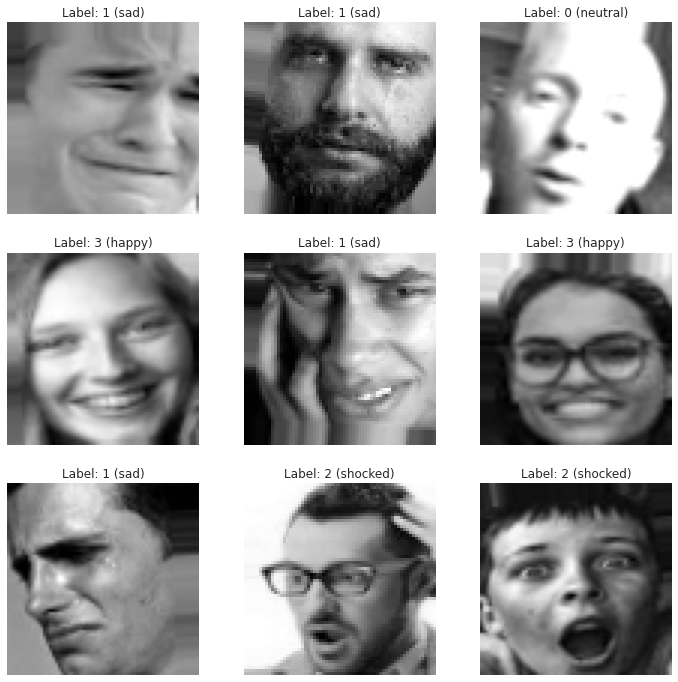

In [67]:
# https://keras.io/api/preprocessing/image/#flow-method
train_generator = train_datagen.flow(x=X_train, y=y_train, 
                                     batch_size=2, 
                                     shuffle=True,
                                     subset="training",
                                     )
validation_generator = train_datagen.flow(x=X_train, y=y_train, 
                                     batch_size=2, 
                                     shuffle=True,
                                     subset="validation",
                                     )
test_generator = test_datagen.flow(x=X_test, y=y_test, 
                                     batch_size=1, 
                                     shuffle=True, 
                                     )
sns.set_style(style="white")
plt.figure(figsize=(12,12))
for i, picture in enumerate(train_generator):
    plt.subplot(3,3,i+1)
    plt.imshow(array_to_img(picture[0][0]), cmap="gray")
    label_num = picture[1][0]
    label_str = "happy" if label_num==3 else "shocked" if label_num==2\
                else "sad" if label_num == 1 else "neutral" 
    plt.title(f"Label: {label_num} ({label_str})")
    plt.axis("off")
    if i == 8:
        break
plt.show()

# 2\. Creating The Model

## 2.1 Shape of The Dataset

In [10]:
from keras import models, layers

In [11]:
print("---Shape of the train set---\nX_train:", X_train.shape, 
      "\ny_train:", y_train.shape)
print("\n---Shape of the test set---\nX_test:", X_test.shape, 
      "\ny_test:", y_test.shape)

---Shape of the train set---
X_train: (576, 64, 64, 1) 
y_train: (576,)

---Shape of the test set---
X_test: (144, 64, 64, 1) 
y_test: (144,)


## 2.2 Neural Network Models

### 2.2.0 TensorBoard Configuration & Monitoring

Here we prepare the TensorBoard configuration to monitor the model's performance below. After creating the model, we will refer to TensorBoard API.

Self reminders:
* To view open TensorBoard instances: <code>tb_notebook.list()</code>

* To kill the current TensorBoard process: <code>!kill #</code> (#:pid number)

* To control TensorBoard display: <code>tb_notebook.display(port=None, height=1000)</code> 
If no port is provided, the most recently launched TensorBoard is used.

In [12]:
from keras.callbacks import TensorBoard
from tensorboard import notebook as tb_notebook

In [13]:
# Load the TensorBoard notebook extension:
%load_ext tensorboard

#### \>>> TensorBoard

In [ ]:
# To run the TensorBoard:
%tensorboard --logdir my_log_dir

Here let me put a snippet of a TensorBoard working on training the data. I thought there was no point of using the original TensorBoard instance *(as well as all the other successful models shown on the image)* since GitHub is not able to show it on the page. Also it bloats the .ipynb file over 10 MB.

 ![TensorBoard Snippet](https://i.pinimg.com/originals/be/0d/ee/be0dee71cbfbfe2b06bf66ae5c60f613.jpg)

### 2.2.1 Model 1
We throw a couple of convolutional and pooling layers with Dropouts and BatchNormalization in our first model. For this part, there will not be any fine tuning of hyperparameters but just a few layer modification (over hidden layers, neurons or dropouts). To see the real magic, save yourself for later!

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(filters=512, 
                        kernel_size=(3, 3),
                        activation="relu", 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.35))

model.add(layers.Conv2D(filters=512,
                        activation="relu",
                        kernel_size=(3, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.35))

model.add(layers.Conv2D(filters=1024,
                        activation="relu",
                        kernel_size=(3, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.50))

model.add(layers.Conv2D(filters=1024,
                        activation="relu",
                        kernel_size=(3, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.50))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(4, activation="softmax", name="Output_Layer"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 512)       5120      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 512)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 31, 512)       2048      
_________________________________________________________________
activation (Activation)      (None, 31, 31, 512)       0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 512)       2359808   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 512)       0

In [33]:
def compile_model(model_number="(null)", epochs=50):
    model.compile(optimizer="adam", 
                loss="sparse_categorical_crossentropy", 
                metrics=["accuracy"])
    # TensorBoard configuration:
    # create a folder for log files
    my_log_dir = os.path.join("my_log_dir", 
                        datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S" + 
                                                         model_number))
    tensorboard_callbacks = TensorBoard(log_dir=my_log_dir,
                                        histogram_freq=1)
    # fit the set:
    model_history = model.fit(train_generator, 
                    batch_size=2, 
                    epochs=epochs, 
                    verbose=0, 
                    validation_data=validation_generator,
                    callbacks=[tensorboard_callbacks]
                    )
    return model_history

In [18]:
model_history = compile_model("(1)")

In [20]:
# cosmetic configuration
def display_graph(model_number="(null)"):
    sns.set(style="whitegrid")
    title_font = {"family":"sans", 
                "color":"darkred", 
                "size":30, 
                "weight":"bold", 
                "alpha":0.9}
    axis_font = {"family":"sans-serif", 
                "color":"black", 
                "size":16, 
                "weight":"bold"}

    # plot the graphs
    plt.figure(figsize=(20,8))
    plt.suptitle("Model: " + model_number, fontdict=title_font)
    plt.subplot(1,2,1)
    plt.plot(range(1, len(model_history.history["accuracy"])+1), 
            model_history.history["accuracy"], 
            color="darkgreen", linewidth=2, label="Train Set")
    plt.plot(range(1, len(model_history.history["val_accuracy"])+1), 
            model_history.history["val_accuracy"], 
            "r--", linewidth=2, label="Valdation Set", alpha=0.8)
    plt.xlabel("Epochs", fontdict=axis_font)
    plt.ylabel("Accuracy Value", fontdict=axis_font)
    plt.legend(fontsize="medium", loc=0)

    plt.subplot(1,2,2)
    plt.plot(range(1, len(model_history.history["loss"])+1), 
            model_history.history["loss"], 
            color="darkgreen", linewidth=2, label="Train Set")
    plt.plot(range(1, len(model_history.history["val_loss"])+1), 
            model_history.history["val_loss"], 
            "r--", linewidth=2, label="Validation Set", alpha=0.7)
    plt.xlabel("Epochs", fontdict=axis_font)
    plt.ylabel("Loss Value", fontdict=axis_font)
    plt.legend(fontsize="medium", loc=0)

    plt.show()

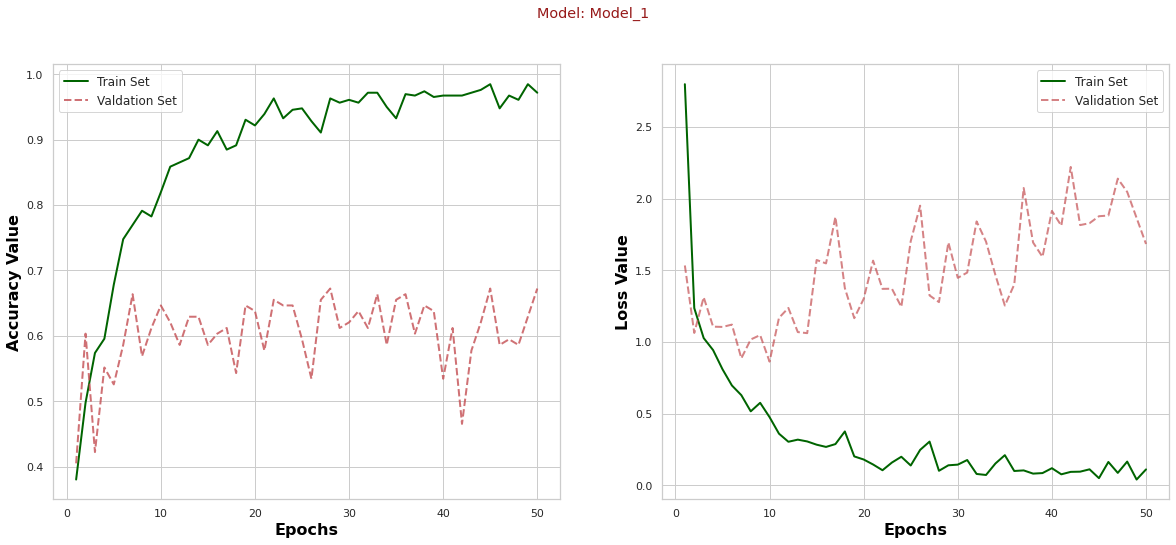

In [21]:
display_graph("Model_1")

In [19]:
model.save("model1_with_180imgs_noGenerated.h5")
model.evaluate(X_test, y_test, batch_size=1)

144/144 [==============================] - 1s 6ms/step - loss: 1.7024 - accuracy: 0.7014


[1.7023940086364746, 0.7013888955116272]

### 2.2.2 Model 2
After 10 epochs, Model 1 seems to fly us to the moon and let us overfit among the stars. Promising but definitely not a successful model! We have to make it simpler, so it shouldn't learn every bit of curves, dots and lines of a human face to call it a "face". That what overfitting does unfortunately. It just has to be a "good-enough" model that provides us a satisfactory approximation, a decent estimation of a sad or a happy human face:<br>
**Changes:**<br>
* BatchNormalization --> before the non-linear (Activation) layer.
* Dropouts --> increased
* Layers --> decreased
* Neurons --> decreased
* Epochs --> same

In [25]:
model = models.Sequential()
model.add(layers.Conv2D(filters=16, 
                        kernel_size=(3, 3), 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.50))

model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.50))

model.add(layers.Flatten())
model.add(layers.Dense(16))
model.add(layers.Activation("relu"))
model.add(layers.Dense(4, activation="softmax", name="Output_Layer"))

model_history = compile_model("(2)")

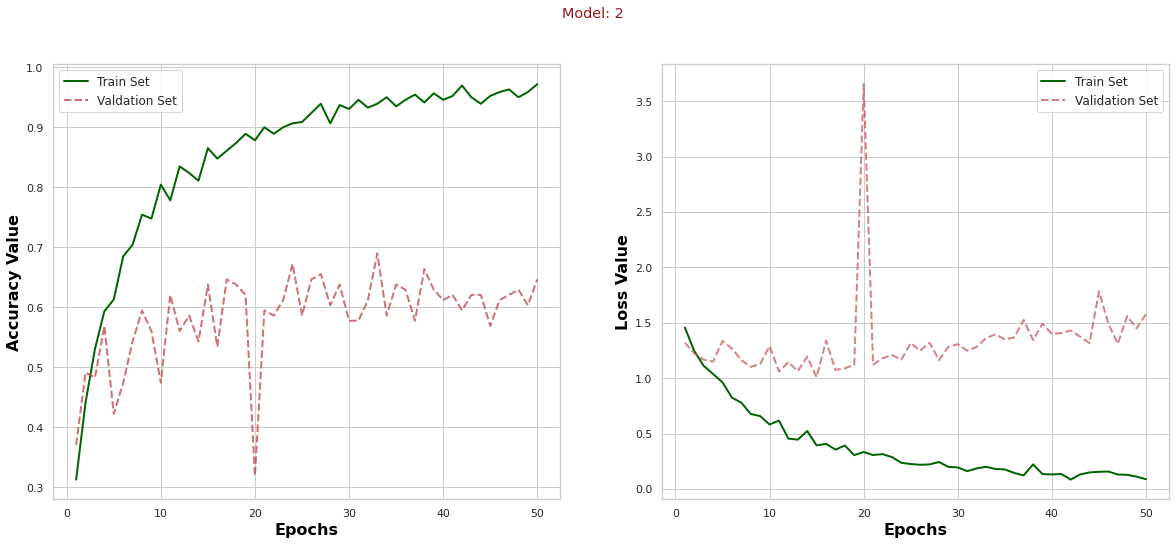

In [26]:
display_graph("2")

In [27]:
model.save("model2_with_180imgs_noGenerated.h5")
model.evaluate(X_test, y_test, batch_size=1)

144/144 [==============================] - 0s 2ms/step - loss: 1.6044 - accuracy: 0.5972


[1.60443913936615, 0.5972222089767456]

### 2.2.3 Model 3
We have a better loss graph but these are just desperate acts! Why don't we stop whistling in the wind and try our generator module?
The accuracy is almost the same but our loss value seems relatively better but still an overfit. Why don't we stop whistling in the wind and try our generator module with a slightly more complex model as in Model 1? Since it will generate images on the go, it will be less likely to overfit.<br>Let's see...<br>
**Changes:**<br>
* Dropouts --> same
* Layers --> increased
* Neurons --> increased
* Epochs --> same
* Image Generator --> activated

In [34]:
model = models.Sequential()
model.add(layers.Conv2D(filters=512, 
                        kernel_size=(3, 3), 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.50))

model.add(layers.Conv2D(filters=512, 
                        kernel_size=(3, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.50))

model.add(layers.Conv2D(filters=1024, 
                        kernel_size=(3, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.50))

model.add(layers.Conv2D(filters=1024, 
                        kernel_size=(3, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.50))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(4, activation="softmax", name="Output_Layer"))

model_history = compile_model("(3)")

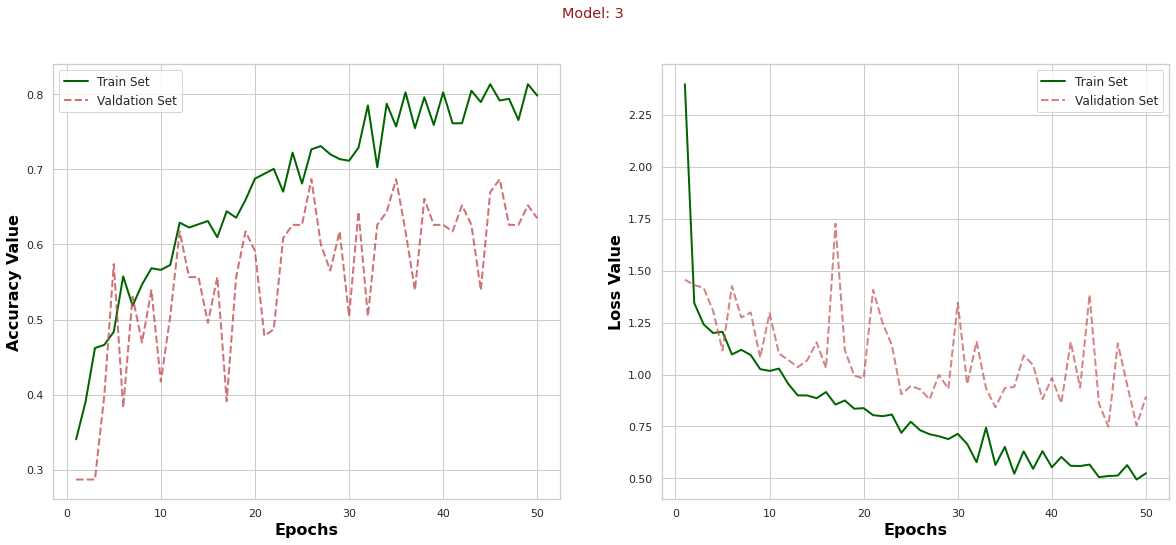

In [35]:
display_graph("3")

In [36]:
model.save("model3_with_180imgs_withGenerated.h5")
model.evaluate(test_generator, batch_size=1)

144/144 [==============================] - 1s 6ms/step - loss: 0.7252 - accuracy: 0.7361


[0.725188136100769, 0.7361111044883728]